# Classifying Developmental Outcome
In this notebook we will be testing various ML classifiers in how well they can forward predict developmental outcome based on: the input channels and the timepoints of those input channels

In [1]:
import organoid_prediction_python as opp
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

home_directory = r"D:\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
table_location = home_directory + "tabular_data"

timecourse_data = pd.read_csv(f"{table_location}/All_Samples_Feature_Space_All_Features_48h,72h,96h_Normalised_per_Timepoint.csv")
timecourse_data

,Run,Plate,ID,048h_raw_BF_AreaShape_area,048h_raw_BF_AreaShape_aspect_ratio,048h_raw_BF_AreaShape_axis_major_length,048h_raw_BF_AreaShape_axis_minor_length,048h_raw_BF_AreaShape_eccentricity,048h_raw_BF_AreaShape_feret_diameter_max,048h_raw_BF_AreaShape_perimeter,...,096h_str_BF_AreaShape_moments_hu_1,096h_str_BF_AreaShape_moments_hu_2,096h_str_BF_AreaShape_moments_hu_3,096h_str_BF_AreaShape_moments_hu_4,096h_str_BF_AreaShape_moments_hu_5,096h_str_BF_AreaShape_moments_hu_6,096h_str_BF_AreaShape_orientation,096h_str_BF_AreaShape_perimeter,096h_str_CH_AreaShape_Bra_MajorAxis_Polarisation,096h_str_CH_AreaShape_Bra_MinorAxis_Polarisation
0,RR,1,A1,0.754091,-0.889636,0.132588,1.204628,-1.000051,0.007074,0.615519,...,-0.769984,-0.768314,-0.188818,-0.081040,-0.108285,-0.018937,0.218694,0.485603,-0.237483,0.204173
1,RR,1,A2,-0.783470,-1.252670,-1.238409,0.003129,-1.752936,-1.131530,-0.724230,...,-0.587974,0.518118,-0.142104,-0.080919,-0.108023,0.017986,-1.310831,-0.276812,-0.930821,1.071650
2,RR,1,A3,1.636441,-0.184192,1.186196,1.565451,-0.008740,1.127225,1.795347,...,-0.724302,-0.679043,-0.186519,-0.081045,-0.108504,-0.019001,-0.638784,0.014028,0.406917,-0.068697
3,RR,1,A4,-0.525754,-0.513477,-0.672134,-0.202863,-0.422446,-0.849309,-0.402853,...,0.276192,-0.326314,0.038707,-0.073034,-0.013521,0.038021,0.362758,0.652506,0.992505,-0.551399
4,RR,1,A5,0.537872,-0.248943,0.294790,0.612413,-0.084969,0.059492,0.498737,...,0.544892,-0.696050,-0.161387,-0.081127,-0.113141,-0.013480,-0.324894,-1.090064,0.285818,-0.643907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,TR,2,H8,-0.342295,-0.103644,-0.319022,-0.266071,0.083062,-0.511010,-0.233997,...,-0.240030,1.252083,-0.031233,-0.076766,-0.095753,0.232280,-0.531978,0.936472,-1.056426,0.770934
763,TR,2,H9,-0.925432,1.281638,-0.116354,-1.536867,1.304509,-0.330223,-1.009869,...,-0.010842,0.858318,-0.018204,-0.084586,-0.137911,0.247706,0.371618,1.965908,0.143556,0.712064
764,TR,2,H10,-1.873304,-1.279234,-2.131125,-1.049808,-1.821515,-2.016265,-1.929328,...,-0.454779,1.044578,-0.117763,-0.082320,-0.115499,0.052699,0.177291,1.923294,-1.128242,-0.816051
765,TR,2,H11,-2.408392,-0.915375,-2.411391,-1.803167,-1.045366,-2.414625,-2.306480,...,1.523053,0.369209,0.161155,-0.101456,-0.309307,0.338411,-0.341009,1.652660,-0.982778,1.840169


Set the features that we will include in each dataset

In [2]:
all_feats = [
    '048h_raw_BF_AreaShape_area',
    '048h_raw_BF_AreaShape_aspect_ratio',
    '048h_raw_BF_AreaShape_axis_major_length',
    '048h_raw_BF_AreaShape_axis_minor_length',
    '048h_raw_BF_AreaShape_eccentricity',
    '048h_raw_BF_AreaShape_feret_diameter_max',
    '048h_raw_BF_AreaShape_perimeter',
    '048h_raw_BF_AreaShape_solidity', '048h_str_BF_AreaShape_area',
    '048h_str_BF_AreaShape_aspect_ratio',
    '048h_str_BF_AreaShape_eccentricity',
    '048h_str_BF_AreaShape_equivalent_diameter',
    '048h_str_BF_AreaShape_extent',
    '048h_str_BF_AreaShape_form_factor',
    '048h_str_BF_AreaShape_inertia_tensor_0_0',
    '048h_str_BF_AreaShape_inertia_tensor_0_1',
    '048h_str_BF_AreaShape_inertia_tensor_1_0',
    '048h_str_BF_AreaShape_inertia_tensor_1_1',
    '048h_str_BF_AreaShape_inertia_tensor_eigvals_0',
    '048h_str_BF_AreaShape_inertia_tensor_eigvals_1',
    '048h_str_BF_AreaShape_locoefa_PC_1',
    '048h_str_BF_AreaShape_locoefa_PC_2',
    '048h_str_BF_AreaShape_locoefa_PC_3',
    '048h_str_BF_AreaShape_locoefa_PC_4',
    '048h_str_BF_AreaShape_locoefa_PC_5',
    '048h_str_BF_AreaShape_locoefa_UMAP_1',
    '048h_str_BF_AreaShape_locoefa_UMAP_2',
    '048h_str_BF_AreaShape_locoefa_UMAP_3',
    '048h_str_BF_AreaShape_locoefa_coeff_0',
    '048h_str_BF_AreaShape_locoefa_coeff_1',
    '048h_str_BF_AreaShape_locoefa_coeff_10',
    '048h_str_BF_AreaShape_locoefa_coeff_11',
    '048h_str_BF_AreaShape_locoefa_coeff_12',
    '048h_str_BF_AreaShape_locoefa_coeff_13',
    '048h_str_BF_AreaShape_locoefa_coeff_14',
    '048h_str_BF_AreaShape_locoefa_coeff_15',
    '048h_str_BF_AreaShape_locoefa_coeff_16',
    '048h_str_BF_AreaShape_locoefa_coeff_17',
    '048h_str_BF_AreaShape_locoefa_coeff_18',
    '048h_str_BF_AreaShape_locoefa_coeff_19',
    '048h_str_BF_AreaShape_locoefa_coeff_2',
    '048h_str_BF_AreaShape_locoefa_coeff_20',
    '048h_str_BF_AreaShape_locoefa_coeff_21',
    '048h_str_BF_AreaShape_locoefa_coeff_22',
    '048h_str_BF_AreaShape_locoefa_coeff_23',
    '048h_str_BF_AreaShape_locoefa_coeff_24',
    '048h_str_BF_AreaShape_locoefa_coeff_25',
    '048h_str_BF_AreaShape_locoefa_coeff_26',
    '048h_str_BF_AreaShape_locoefa_coeff_27',
    '048h_str_BF_AreaShape_locoefa_coeff_28',
    '048h_str_BF_AreaShape_locoefa_coeff_29',
    '048h_str_BF_AreaShape_locoefa_coeff_3',
    '048h_str_BF_AreaShape_locoefa_coeff_30',
    '048h_str_BF_AreaShape_locoefa_coeff_31',
    '048h_str_BF_AreaShape_locoefa_coeff_32',
    '048h_str_BF_AreaShape_locoefa_coeff_33',
    '048h_str_BF_AreaShape_locoefa_coeff_34',
    '048h_str_BF_AreaShape_locoefa_coeff_35',
    '048h_str_BF_AreaShape_locoefa_coeff_36',
    '048h_str_BF_AreaShape_locoefa_coeff_37',
    '048h_str_BF_AreaShape_locoefa_coeff_38',
    '048h_str_BF_AreaShape_locoefa_coeff_39',
    '048h_str_BF_AreaShape_locoefa_coeff_4',
    '048h_str_BF_AreaShape_locoefa_coeff_40',
    '048h_str_BF_AreaShape_locoefa_coeff_41',
    '048h_str_BF_AreaShape_locoefa_coeff_42',
    '048h_str_BF_AreaShape_locoefa_coeff_43',
    '048h_str_BF_AreaShape_locoefa_coeff_44',
    '048h_str_BF_AreaShape_locoefa_coeff_45',
    '048h_str_BF_AreaShape_locoefa_coeff_46',
    '048h_str_BF_AreaShape_locoefa_coeff_47',
    '048h_str_BF_AreaShape_locoefa_coeff_48',
    '048h_str_BF_AreaShape_locoefa_coeff_49',
    '048h_str_BF_AreaShape_locoefa_coeff_5',
    '048h_str_BF_AreaShape_locoefa_coeff_50',
    '048h_str_BF_AreaShape_locoefa_coeff_51',
    '048h_str_BF_AreaShape_locoefa_coeff_6',
    '048h_str_BF_AreaShape_locoefa_coeff_7',
    '048h_str_BF_AreaShape_locoefa_coeff_8',
    '048h_str_BF_AreaShape_locoefa_coeff_9',
    '048h_str_BF_AreaShape_major_axis_length',
    '048h_str_BF_AreaShape_minor_axis_length',
    '048h_str_BF_AreaShape_moments_hu_0',
    '048h_str_BF_AreaShape_moments_hu_1',
    '048h_str_BF_AreaShape_moments_hu_2',
    '048h_str_BF_AreaShape_moments_hu_3',
    '048h_str_BF_AreaShape_moments_hu_4',
    '048h_str_BF_AreaShape_moments_hu_5',
    '048h_str_BF_AreaShape_moments_hu_6',
    '048h_str_BF_AreaShape_perimeter', '072h_raw_BF_AreaShape_area',
    '072h_raw_BF_AreaShape_aspect_ratio',
    '072h_raw_BF_AreaShape_axis_major_length',
    '072h_raw_BF_AreaShape_axis_minor_length',
    '072h_raw_BF_AreaShape_eccentricity',
    '072h_raw_BF_AreaShape_feret_diameter_max',
    '072h_raw_BF_AreaShape_perimeter',
    '072h_raw_BF_AreaShape_solidity',
    '072h_raw_CH__bf_mask_Intensity_IntegratedIntensity',
    '072h_raw_CH__bf_mask_Intensity_IntegratedIntensityEdge',
    '072h_raw_CH__bf_mask_Intensity_LowerQuartileIntensity',
    '072h_raw_CH__bf_mask_Intensity_MADIntensity',
    '072h_raw_CH__bf_mask_Intensity_MassDisplacement',
    '072h_raw_CH__bf_mask_Intensity_MaxIntensity',
    '072h_raw_CH__bf_mask_Intensity_MaxIntensityEdge',
    '072h_raw_CH__bf_mask_Intensity_MeanIntensity',
    '072h_raw_CH__bf_mask_Intensity_MeanIntensityEdge',
    '072h_raw_CH__bf_mask_Intensity_MedianIntensity',
    '072h_raw_CH__bf_mask_Intensity_MinIntensity',
    '072h_raw_CH__bf_mask_Intensity_MinIntensityEdge',
    '072h_raw_CH__bf_mask_Intensity_StdIntensity',
    '072h_raw_CH__bf_mask_Intensity_StdIntensityEdge',
    '072h_raw_CH__bf_mask_Intensity_UpperQuartileIntensity',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_1of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_2of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_3of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_4of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_5of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_6of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_7of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_8of9',
    '072h_raw_CH__bf_mask_RadialDistribution_FracAtD_9of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_1of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_2of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_3of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_4of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_5of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_6of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_7of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_8of9',
    '072h_raw_CH__bf_mask_RadialDistribution_MeanFrac_9of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_1of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_2of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_3of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_4of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_5of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_6of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_7of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_8of9',
    '072h_raw_CH__bf_mask_RadialDistribution_RadialCV_9of9',
    '072h_str_BF_AreaShape_area', '072h_str_BF_AreaShape_aspect_ratio',
    '072h_str_BF_AreaShape_eccentricity',
    '072h_str_BF_AreaShape_equivalent_diameter',
    '072h_str_BF_AreaShape_extent',
    '072h_str_BF_AreaShape_form_factor',
    '072h_str_BF_AreaShape_inertia_tensor_0_0',
    '072h_str_BF_AreaShape_inertia_tensor_0_1',
    '072h_str_BF_AreaShape_inertia_tensor_1_0',
    '072h_str_BF_AreaShape_inertia_tensor_1_1',
    '072h_str_BF_AreaShape_inertia_tensor_eigvals_0',
    '072h_str_BF_AreaShape_inertia_tensor_eigvals_1',
    '072h_str_BF_AreaShape_locoefa_PC_1',
    '072h_str_BF_AreaShape_locoefa_PC_2',
    '072h_str_BF_AreaShape_locoefa_PC_3',
    '072h_str_BF_AreaShape_locoefa_PC_4',
    '072h_str_BF_AreaShape_locoefa_PC_5',
    '072h_str_BF_AreaShape_locoefa_UMAP_1',
    '072h_str_BF_AreaShape_locoefa_UMAP_2',
    '072h_str_BF_AreaShape_locoefa_UMAP_3',
    '072h_str_BF_AreaShape_locoefa_coeff_0',
    '072h_str_BF_AreaShape_locoefa_coeff_1',
    '072h_str_BF_AreaShape_locoefa_coeff_10',
    '072h_str_BF_AreaShape_locoefa_coeff_11',
    '072h_str_BF_AreaShape_locoefa_coeff_12',
    '072h_str_BF_AreaShape_locoefa_coeff_13',
    '072h_str_BF_AreaShape_locoefa_coeff_14',
    '072h_str_BF_AreaShape_locoefa_coeff_15',
    '072h_str_BF_AreaShape_locoefa_coeff_16',
    '072h_str_BF_AreaShape_locoefa_coeff_17',
    '072h_str_BF_AreaShape_locoefa_coeff_18',
    '072h_str_BF_AreaShape_locoefa_coeff_19',
    '072h_str_BF_AreaShape_locoefa_coeff_2',
    '072h_str_BF_AreaShape_locoefa_coeff_20',
    '072h_str_BF_AreaShape_locoefa_coeff_21',
    '072h_str_BF_AreaShape_locoefa_coeff_22',
    '072h_str_BF_AreaShape_locoefa_coeff_23',
    '072h_str_BF_AreaShape_locoefa_coeff_24',
    '072h_str_BF_AreaShape_locoefa_coeff_25',
    '072h_str_BF_AreaShape_locoefa_coeff_26',
    '072h_str_BF_AreaShape_locoefa_coeff_27',
    '072h_str_BF_AreaShape_locoefa_coeff_28',
    '072h_str_BF_AreaShape_locoefa_coeff_29',
    '072h_str_BF_AreaShape_locoefa_coeff_3',
    '072h_str_BF_AreaShape_locoefa_coeff_30',
    '072h_str_BF_AreaShape_locoefa_coeff_31',
    '072h_str_BF_AreaShape_locoefa_coeff_32',
    '072h_str_BF_AreaShape_locoefa_coeff_33',
    '072h_str_BF_AreaShape_locoefa_coeff_34',
    '072h_str_BF_AreaShape_locoefa_coeff_35',
    '072h_str_BF_AreaShape_locoefa_coeff_36',
    '072h_str_BF_AreaShape_locoefa_coeff_37',
    '072h_str_BF_AreaShape_locoefa_coeff_38',
    '072h_str_BF_AreaShape_locoefa_coeff_39',
    '072h_str_BF_AreaShape_locoefa_coeff_4',
    '072h_str_BF_AreaShape_locoefa_coeff_40',
    '072h_str_BF_AreaShape_locoefa_coeff_41',
    '072h_str_BF_AreaShape_locoefa_coeff_42',
    '072h_str_BF_AreaShape_locoefa_coeff_43',
    '072h_str_BF_AreaShape_locoefa_coeff_44',
    '072h_str_BF_AreaShape_locoefa_coeff_45',
    '072h_str_BF_AreaShape_locoefa_coeff_46',
    '072h_str_BF_AreaShape_locoefa_coeff_47',
    '072h_str_BF_AreaShape_locoefa_coeff_48',
    '072h_str_BF_AreaShape_locoefa_coeff_49',
    '072h_str_BF_AreaShape_locoefa_coeff_5',
    '072h_str_BF_AreaShape_locoefa_coeff_50',
    '072h_str_BF_AreaShape_locoefa_coeff_51',
    '072h_str_BF_AreaShape_locoefa_coeff_6',
    '072h_str_BF_AreaShape_locoefa_coeff_7',
    '072h_str_BF_AreaShape_locoefa_coeff_8',
    '072h_str_BF_AreaShape_locoefa_coeff_9',
    '072h_str_BF_AreaShape_major_axis_length',
    '072h_str_BF_AreaShape_minor_axis_length',
    '072h_str_BF_AreaShape_moments_hu_0',
    '072h_str_BF_AreaShape_moments_hu_1',
    '072h_str_BF_AreaShape_moments_hu_2',
    '072h_str_BF_AreaShape_moments_hu_3',
    '072h_str_BF_AreaShape_moments_hu_4',
    '072h_str_BF_AreaShape_moments_hu_5',
    '072h_str_BF_AreaShape_moments_hu_6',
    '072h_str_BF_AreaShape_perimeter',
    '072h_str_CH_AreaShape_Bra_MajorAxis_Polarisation',
    '072h_str_CH_AreaShape_Bra_MinorAxis_Polarisation',
    '096h_raw_BF_AreaShape_area', '096h_raw_BF_AreaShape_aspect_ratio',
    '096h_raw_BF_AreaShape_axis_major_length',
    '096h_raw_BF_AreaShape_axis_minor_length',
    '096h_raw_BF_AreaShape_eccentricity',
    '096h_raw_BF_AreaShape_feret_diameter_max',
    '096h_raw_BF_AreaShape_perimeter',
    '096h_raw_BF_AreaShape_solidity',
    '096h_raw_CH_AreaShape_Bra_AreaFraction',
    '096h_raw_CH__bf_mask_Intensity_IntegratedIntensity',
    '096h_raw_CH__bf_mask_Intensity_IntegratedIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_LowerQuartileIntensity',
    '096h_raw_CH__bf_mask_Intensity_MADIntensity',
    '096h_raw_CH__bf_mask_Intensity_MassDisplacement',
    '096h_raw_CH__bf_mask_Intensity_MaxIntensity',
    '096h_raw_CH__bf_mask_Intensity_MaxIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_MeanIntensity',
    '096h_raw_CH__bf_mask_Intensity_MeanIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_MedianIntensity',
    '096h_raw_CH__bf_mask_Intensity_MinIntensity',
    '096h_raw_CH__bf_mask_Intensity_MinIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_StdIntensity',
    '096h_raw_CH__bf_mask_Intensity_StdIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_UpperQuartileIntensity',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_1of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_2of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_3of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_4of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_5of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_6of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_7of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_8of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_9of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_1of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_2of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_3of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_4of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_5of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_6of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_7of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_8of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_9of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_1of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_2of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_3of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_4of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_5of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_6of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_7of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_8of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_9of9',
    '096h_raw_CH_bra_mask_AreaShape_Area',
    '096h_raw_CH_bra_mask_AreaShape_BoundingBoxArea',
    '096h_raw_CH_bra_mask_AreaShape_Compactness',
    '096h_raw_CH_bra_mask_AreaShape_ConvexArea',
    '096h_raw_CH_bra_mask_AreaShape_Eccentricity',
    '096h_raw_CH_bra_mask_AreaShape_EquivalentDiameter',
    '096h_raw_CH_bra_mask_AreaShape_EulerNumber',
    '096h_raw_CH_bra_mask_AreaShape_Extent',
    '096h_raw_CH_bra_mask_AreaShape_FormFactor',
    '096h_raw_CH_bra_mask_AreaShape_MajorAxisLength',
    '096h_raw_CH_bra_mask_AreaShape_MaxFeretDiameter',
    '096h_raw_CH_bra_mask_AreaShape_MaximumRadius',
    '096h_raw_CH_bra_mask_AreaShape_MeanRadius',
    '096h_raw_CH_bra_mask_AreaShape_MedianRadius',
    '096h_raw_CH_bra_mask_AreaShape_MinFeretDiameter',
    '096h_raw_CH_bra_mask_AreaShape_MinorAxisLength',
    '096h_raw_CH_bra_mask_AreaShape_Perimeter',
    '096h_raw_CH_bra_mask_AreaShape_Solidity',
    '096h_raw_CH_bra_mask_Intensity_IntegratedIntensity',
    '096h_raw_CH_bra_mask_Intensity_IntegratedIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_LowerQuartileIntensity',
    '096h_raw_CH_bra_mask_Intensity_MADIntensity',
    '096h_raw_CH_bra_mask_Intensity_MassDisplacement',
    '096h_raw_CH_bra_mask_Intensity_MaxIntensity',
    '096h_raw_CH_bra_mask_Intensity_MaxIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_MeanIntensity',
    '096h_raw_CH_bra_mask_Intensity_MeanIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_MedianIntensity',
    '096h_raw_CH_bra_mask_Intensity_MinIntensity',
    '096h_raw_CH_bra_mask_Intensity_MinIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_StdIntensity',
    '096h_raw_CH_bra_mask_Intensity_StdIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_UpperQuartileIntensity',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_1of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_2of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_3of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_4of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_5of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_6of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_7of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_8of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_9of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_1of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_2of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_3of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_4of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_5of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_6of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_7of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_8of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_9of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_1of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_2of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_3of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_4of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_5of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_6of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_7of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_8of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_9of9',
    '096h_str_BF_AreaShape_area', '096h_str_BF_AreaShape_aspect_ratio',
    '096h_str_BF_AreaShape_eccentricity',
    '096h_str_BF_AreaShape_equivalent_diameter',
    '096h_str_BF_AreaShape_extent',
    '096h_str_BF_AreaShape_form_factor',
    '096h_str_BF_AreaShape_inertia_tensor_0_0',
    '096h_str_BF_AreaShape_inertia_tensor_0_1',
    '096h_str_BF_AreaShape_inertia_tensor_1_0',
    '096h_str_BF_AreaShape_inertia_tensor_1_1',
    '096h_str_BF_AreaShape_inertia_tensor_eigvals_0',
    '096h_str_BF_AreaShape_inertia_tensor_eigvals_1',
    '096h_str_BF_AreaShape_locoefa_PC_1',
    '096h_str_BF_AreaShape_locoefa_PC_2',
    '096h_str_BF_AreaShape_locoefa_PC_3',
    '096h_str_BF_AreaShape_locoefa_PC_4',
    '096h_str_BF_AreaShape_locoefa_PC_5',
    '096h_str_BF_AreaShape_locoefa_UMAP_1',
    '096h_str_BF_AreaShape_locoefa_UMAP_2',
    '096h_str_BF_AreaShape_locoefa_UMAP_3',
    '096h_str_BF_AreaShape_locoefa_coeff_0',
    '096h_str_BF_AreaShape_locoefa_coeff_1',
    '096h_str_BF_AreaShape_locoefa_coeff_10',
    '096h_str_BF_AreaShape_locoefa_coeff_11',
    '096h_str_BF_AreaShape_locoefa_coeff_12',
    '096h_str_BF_AreaShape_locoefa_coeff_13',
    '096h_str_BF_AreaShape_locoefa_coeff_14',
    '096h_str_BF_AreaShape_locoefa_coeff_15',
    '096h_str_BF_AreaShape_locoefa_coeff_16',
    '096h_str_BF_AreaShape_locoefa_coeff_17',
    '096h_str_BF_AreaShape_locoefa_coeff_18',
    '096h_str_BF_AreaShape_locoefa_coeff_19',
    '096h_str_BF_AreaShape_locoefa_coeff_2',
    '096h_str_BF_AreaShape_locoefa_coeff_20',
    '096h_str_BF_AreaShape_locoefa_coeff_21',
    '096h_str_BF_AreaShape_locoefa_coeff_22',
    '096h_str_BF_AreaShape_locoefa_coeff_23',
    '096h_str_BF_AreaShape_locoefa_coeff_24',
    '096h_str_BF_AreaShape_locoefa_coeff_25',
    '096h_str_BF_AreaShape_locoefa_coeff_26',
    '096h_str_BF_AreaShape_locoefa_coeff_27',
    '096h_str_BF_AreaShape_locoefa_coeff_28',
    '096h_str_BF_AreaShape_locoefa_coeff_29',
    '096h_str_BF_AreaShape_locoefa_coeff_3',
    '096h_str_BF_AreaShape_locoefa_coeff_30',
    '096h_str_BF_AreaShape_locoefa_coeff_31',
    '096h_str_BF_AreaShape_locoefa_coeff_32',
    '096h_str_BF_AreaShape_locoefa_coeff_33',
    '096h_str_BF_AreaShape_locoefa_coeff_34',
    '096h_str_BF_AreaShape_locoefa_coeff_35',
    '096h_str_BF_AreaShape_locoefa_coeff_36',
    '096h_str_BF_AreaShape_locoefa_coeff_37',
    '096h_str_BF_AreaShape_locoefa_coeff_38',
    '096h_str_BF_AreaShape_locoefa_coeff_39',
    '096h_str_BF_AreaShape_locoefa_coeff_4',
    '096h_str_BF_AreaShape_locoefa_coeff_40',
    '096h_str_BF_AreaShape_locoefa_coeff_41',
    '096h_str_BF_AreaShape_locoefa_coeff_42',
    '096h_str_BF_AreaShape_locoefa_coeff_43',
    '096h_str_BF_AreaShape_locoefa_coeff_44',
    '096h_str_BF_AreaShape_locoefa_coeff_45',
    '096h_str_BF_AreaShape_locoefa_coeff_46',
    '096h_str_BF_AreaShape_locoefa_coeff_47',
    '096h_str_BF_AreaShape_locoefa_coeff_48',
    '096h_str_BF_AreaShape_locoefa_coeff_49',
    '096h_str_BF_AreaShape_locoefa_coeff_5',
    '096h_str_BF_AreaShape_locoefa_coeff_50',
    '096h_str_BF_AreaShape_locoefa_coeff_51',
    '096h_str_BF_AreaShape_locoefa_coeff_6',
    '096h_str_BF_AreaShape_locoefa_coeff_7',
    '096h_str_BF_AreaShape_locoefa_coeff_8',
    '096h_str_BF_AreaShape_locoefa_coeff_9',
    '096h_str_BF_AreaShape_major_axis_length',
    '096h_str_BF_AreaShape_minor_axis_length',
    '096h_str_BF_AreaShape_moments_hu_0',
    '096h_str_BF_AreaShape_moments_hu_1',
    '096h_str_BF_AreaShape_moments_hu_2',
    '096h_str_BF_AreaShape_moments_hu_3',
    '096h_str_BF_AreaShape_moments_hu_4',
    '096h_str_BF_AreaShape_moments_hu_5',
    '096h_str_BF_AreaShape_moments_hu_6',
    '096h_str_BF_AreaShape_perimeter',
    '096h_str_CH_AreaShape_Bra_MajorAxis_Polarisation',
    '096h_str_CH_AreaShape_Bra_MinorAxis_Polarisation'
]

Make Subsets of the Dataframes and add the Annotations

In [3]:
all_feature_lists = {}

hour_dict = dict(map(lambda i,j : (i,j) , ["48-72h","96h","alltp"],[["048h","072h"],["096h"],["048h","072h","096h"]]))
channel_dict = dict(map(lambda i,j : (i,j) , ["bf","bra","both"],[["BF"],["CH"],["BF","CH"]]))

for hour_label,hours in hour_dict.items():
    for channel_label, channels in channel_dict.items():
        all_feature_lists[f"{hour_label}_{channel_label}"] = [
            feat for feat in all_feats 
            if any(
                [hour in feat for hour in hours]
            ) and any(
                [channel in feat for channel in channels]
            )
        ]


all_feature_sets = {key:pd.concat([timecourse_data[val],timecourse_data[["Run","Plate","ID"]]],axis=1) for key,val in all_feature_lists.items()}
# loading annotations
annotations = table_location + "/annotations_with_indices.csv"
annotation_df = pd.read_csv(annotations)
mapping = {"Real_Run":"RR", "Trial_Run":"TR"}
annotation_df["Run"] = [mapping[value] for value in annotation_df["Run"].to_numpy()]
no_na_annot = annotation_df[annotation_df["Morph_Class"]!="NA_NA"]

all_feature_sets = {key:df.merge(no_na_annot,on=["Run","Plate","ID"]) for key,df in all_feature_sets.items()}
all_feature_sets = {key:df[df["Morph"]!="unclassified"].dropna() for key,df in all_feature_sets.items()}
all_feature_sets["48-72h_both"]

,048h_raw_BF_AreaShape_area,048h_raw_BF_AreaShape_aspect_ratio,048h_raw_BF_AreaShape_axis_major_length,048h_raw_BF_AreaShape_axis_minor_length,048h_raw_BF_AreaShape_eccentricity,048h_raw_BF_AreaShape_feret_diameter_max,048h_raw_BF_AreaShape_perimeter,048h_raw_BF_AreaShape_solidity,048h_str_BF_AreaShape_area,048h_str_BF_AreaShape_aspect_ratio,...,072h_str_BF_AreaShape_moments_hu_6,072h_str_BF_AreaShape_perimeter,072h_str_CH_AreaShape_Bra_MajorAxis_Polarisation,072h_str_CH_AreaShape_Bra_MinorAxis_Polarisation,Run,Plate,ID,Axes,Morph,Morph_Class
0,0.754091,-0.889636,0.132588,1.204628,-1.000051,0.007074,0.615519,0.319817,0.843426,-0.420151,...,-0.014919,1.586625,2.227379,-0.598532,RR,1,A1,single,good,single_good
1,-0.783470,-1.252670,-1.238409,0.003129,-1.752936,-1.131530,-0.724230,-0.220483,-0.725872,-1.162351,...,0.012963,-1.014957,2.069796,-1.182707,RR,1,A2,single,bad,single_bad
2,1.636441,-0.184192,1.186196,1.565451,-0.008740,1.127225,1.795347,-0.290298,1.809646,0.320348,...,-0.020550,1.718106,-0.235515,-0.604653,RR,1,A3,single,bad,single_bad
3,-0.525754,-0.513477,-0.672134,-0.202863,-0.422446,-0.849309,-0.402853,0.489570,-0.481615,-0.344829,...,-0.057463,-0.118754,-0.010792,0.747780,RR,1,A4,single,good,single_good
4,0.537872,-0.248943,0.294790,0.612413,-0.084969,0.059492,0.498737,0.504772,0.508383,-0.331238,...,2.754113,0.576026,0.491296,-1.096685,RR,1,A5,single,bad,single_bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-1.801231,0.189615,-1.378837,-1.801012,0.392510,-1.263560,-1.668959,-1.058500,-1.858532,0.026620,...,-0.055293,-1.738433,-0.546494,-0.447613,TR,2,H4,single,good,single_good
430,-1.805599,0.135760,-1.400417,-1.768377,0.338334,-1.393948,-2.002972,0.166579,-1.845563,-0.324757,...,-0.055490,-1.465463,0.565962,4.216196,TR,2,H5,single,bad,single_bad
434,-0.925432,1.281638,-0.116354,-1.536867,1.304509,-0.330223,-1.009869,0.020970,-1.037137,1.124503,...,-0.055223,-1.811582,1.109458,-1.050026,TR,2,H9,single,good,single_good
436,-2.408392,-0.915375,-2.411391,-1.803167,-1.045366,-2.414625,-2.306480,-0.596440,-2.507002,-1.049264,...,-0.055214,-2.184405,-0.131288,1.087728,TR,2,H11,single,good,single_good


Fit and Train Models: We use nested cross validation to mitigate overfitting, while allowing for hyperparameter tuning:

In [6]:
%%time
from tqdm.auto import tqdm

gt_keys = ["Run","Plate","ID","Axes","Morph","Morph_Class"]
results = {}

model_name =["SVC","RF","LDA","XG Boost"]

models = [
    SVC(),RandomForestClassifier(random_state=1,n_jobs=1),LDA(),XGBClassifier(tree_method='gpu_hist', gpu_id=0, learning_rate = 0.01,n_jobs=1)
]
spaces = [
    {'C': [1, 5, 10, 20, 50], 'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
    {'n_estimators': [10, 100, 500],'max_features': [10, 50, 100, 458]},
    {'solver':('svd', 'lsqr', 'eigen')},
    {'max_depth': [2, 4,6],'n_estimators': [50, 200, 500],}
    
]

for name, df in tqdm(all_feature_sets.items(),total = len(all_feature_sets.keys())):
    results[name] = {}
    y = []
    for morph in df["Morph"].to_numpy():
        if morph == "good":
            y.append(1)
        elif morph == "bad":
            y.append(0)
    y = np.array(y)
    X = df.drop(gt_keys,axis=1)
    
    for mod_name, model, space in zip(model_name,models,spaces):
        print(f"{name}, {mod_name}")
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

        # define search
        search = GridSearchCV(model, space, scoring='roc_auc', n_jobs=1, cv=cv_inner, refit=True)
        # configure the cross-validation procedure
        cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        # execute the nested cross-validation
        scores = cross_val_score(search, X, y, scoring='balanced_accuracy', cv=cv_outer, n_jobs=10)
        # report performance
        print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
        results[name][mod_name] = scores 

  0%|          | 0/9 [00:00<?, ?it/s]

48-72h_bf, SVC
Accuracy: 0.542 (0.063)
48-72h_bf, RF
Accuracy: 0.561 (0.063)
48-72h_bf, LDA
Accuracy: 0.538 (0.103)
48-72h_bf, XG Boost
Accuracy: 0.549 (0.045)
48-72h_bra, SVC
Accuracy: 0.599 (0.087)
48-72h_bra, RF
Accuracy: 0.629 (0.084)
48-72h_bra, LDA
Accuracy: 0.605 (0.077)
48-72h_bra, XG Boost
Accuracy: 0.615 (0.114)
48-72h_both, SVC
Accuracy: 0.680 (0.101)
48-72h_both, RF
Accuracy: 0.674 (0.104)
48-72h_both, LDA
Accuracy: 0.536 (0.106)
48-72h_both, XG Boost
Accuracy: 0.636 (0.079)
96h_bf, SVC
Accuracy: 0.583 (0.034)
96h_bf, RF
Accuracy: 0.619 (0.057)
96h_bf, LDA
Accuracy: 0.537 (0.083)
96h_bf, XG Boost
Accuracy: 0.620 (0.051)
96h_bra, SVC
Accuracy: 0.721 (0.057)
96h_bra, RF
Accuracy: 0.710 (0.062)
96h_bra, LDA
Accuracy: 0.678 (0.059)
96h_bra, XG Boost
Accuracy: 0.724 (0.064)
96h_both, SVC
Accuracy: 0.714 (0.033)
96h_both, RF
Accuracy: 0.697 (0.071)
96h_both, LDA
Accuracy: 0.575 (0.077)
96h_both, XG Boost
Accuracy: 0.701 (0.077)
alltp_bf, SVC
Accuracy: 0.627 (0.075)
alltp_bf, RF
A

Collect all results and plot:

In [7]:
all_data = []
for name, diction in results.items():
    for k, v in diction.items():
        scores = v
        all_data.append(pd.DataFrame({"Accuracy":scores,"Classifier":np.full(len(scores), k),"Feature Set":np.full(len(scores), name)}))
    
all_classifier_results_df = pd.concat(all_data,axis=0,ignore_index=True)
all_classifier_results_df

,Accuracy,Classifier,Feature Set
0,0.627530,SVC,48-72h_bf
1,0.532051,SVC,48-72h_bf
2,0.538462,SVC,48-72h_bf
3,0.636752,SVC,48-72h_bf
4,0.510684,SVC,48-72h_bf
...,...,...,...
355,0.668803,XG Boost,alltp_both
356,0.752137,XG Boost,alltp_both
357,0.923077,XG Boost,alltp_both
358,0.754386,XG Boost,alltp_both


In [8]:
all_classifier_results_df.to_csv("Morph Classification Results timepoints and channels AUROC tuning.csv")

In [9]:
standard_dev = pd.DataFrame(all_classifier_results_df.groupby(["Classifier","Feature Set"])['Accuracy'].std()).reset_index().rename(columns={"Accuracy":"Std Dev"})
standard_dev

,Classifier,Feature Set,Std Dev
0,LDA,48-72h_bf,0.108153
1,LDA,48-72h_both,0.111339
2,LDA,48-72h_bra,0.080758
3,LDA,96h_bf,0.087465
4,LDA,96h_both,0.080928
5,LDA,96h_bra,0.062314
6,LDA,alltp_bf,0.068915
7,LDA,alltp_both,0.075660
8,LDA,alltp_bra,0.055895
9,RF,48-72h_bf,0.066581


In [10]:
sns.set_style({
    'axes.facecolor': '#EAEAF2',
    'axes.edgecolor': '2f2f2f',
    'axes.grid': False,
    'axes.axisbelow': 'line',
    'axes.labelcolor': '.15',
    'figure.facecolor': 'white',
    'grid.color': '#3f3f3f',
    'grid.linestyle': '-',
    'text.color': 'black',
    'xtick.color': '2f2f2f',
    'ytick.color': '2f2f2f',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    #'lines.solid_capstyle': <CapStyle.projecting: 'projecting'>,
    #'patch.edgecolor': 'black',
    'patch.force_edgecolor': False,
    
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': True,
    'ytick.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
})

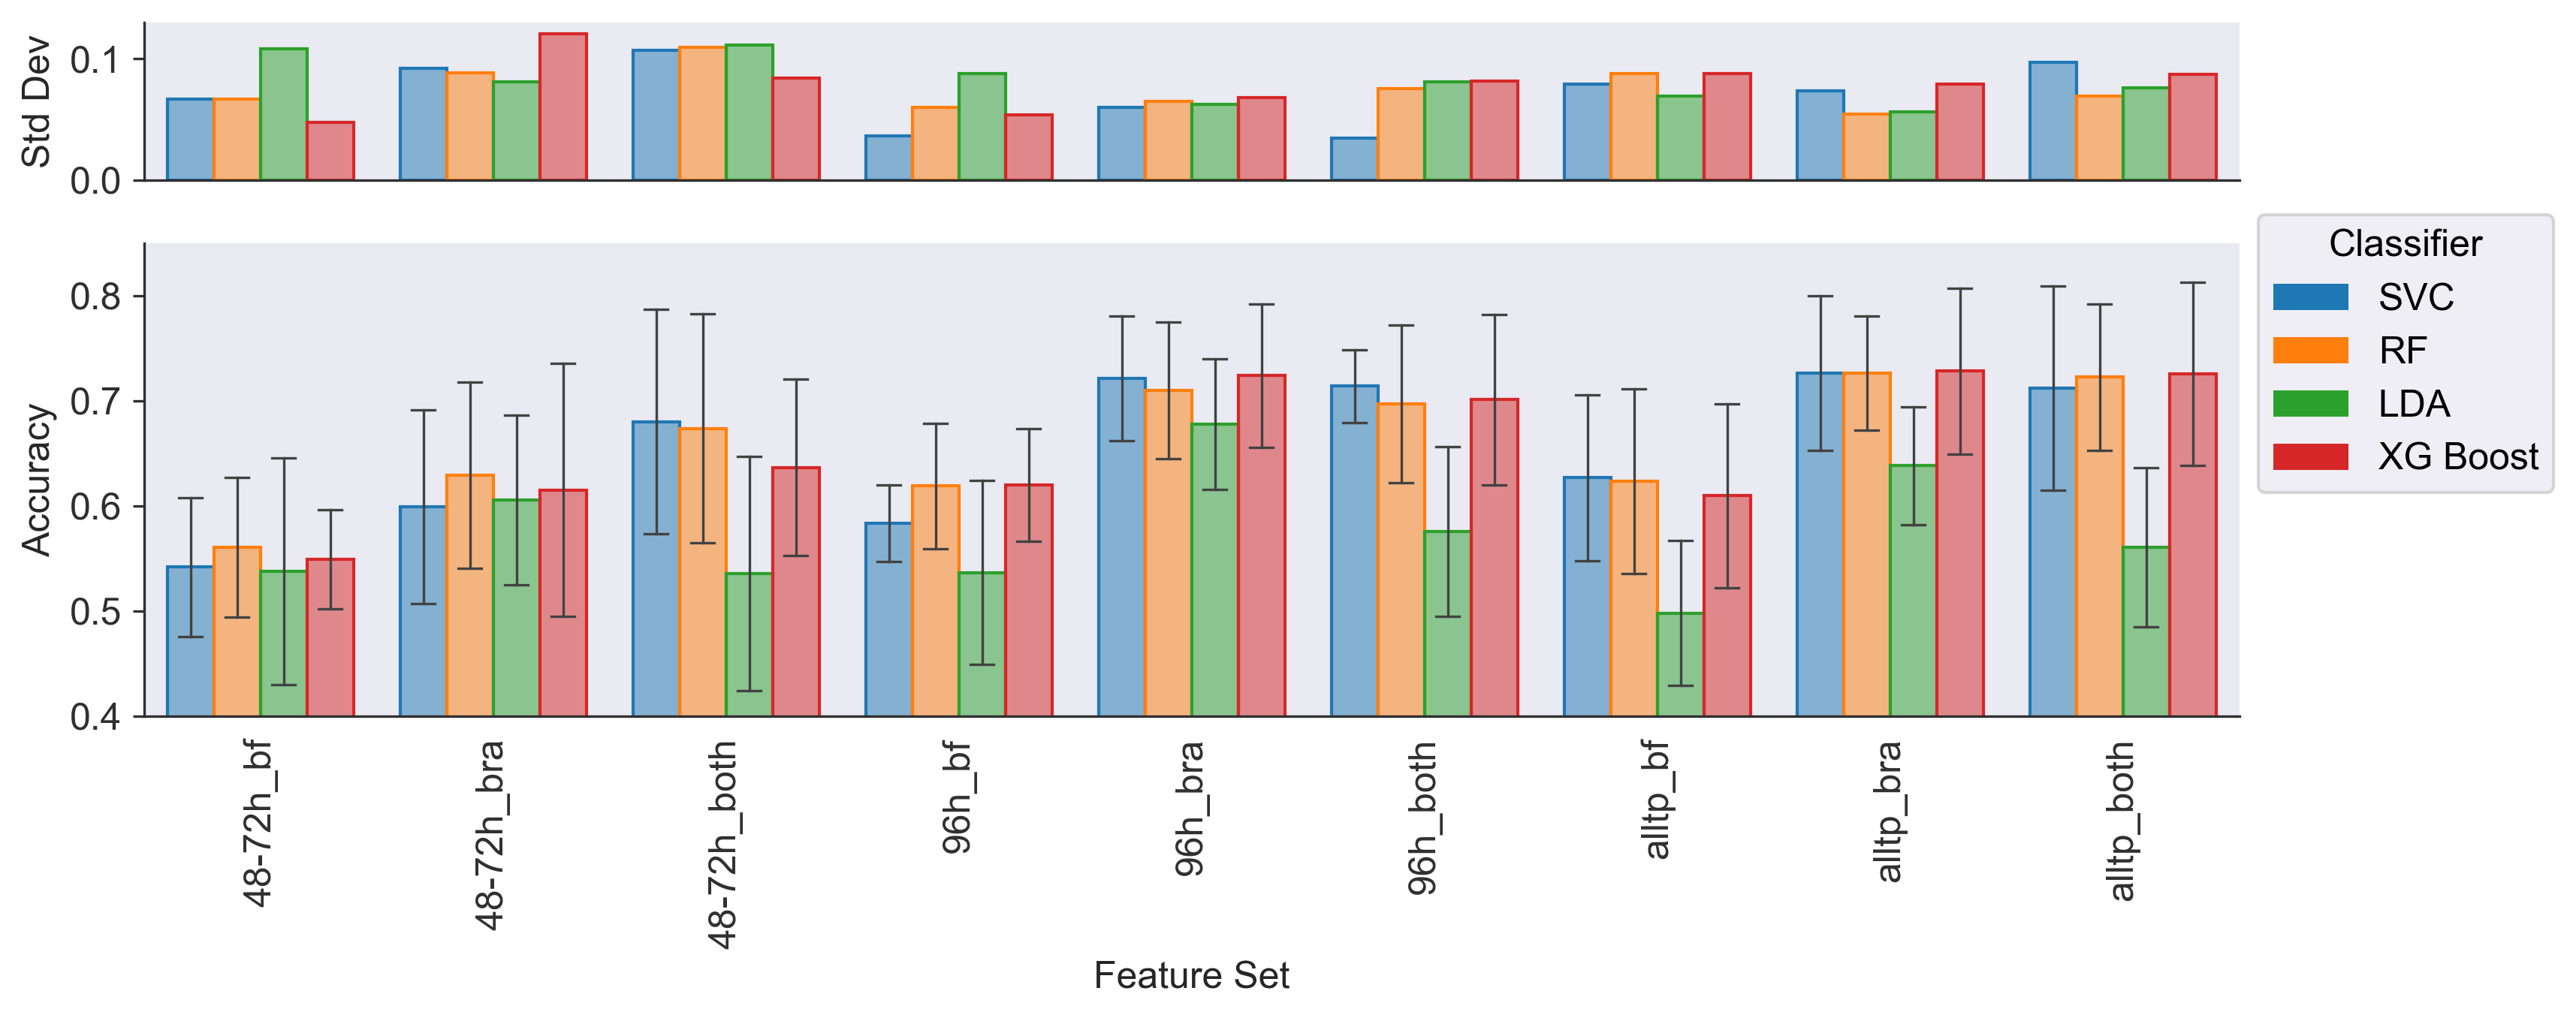

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

out_fig_2 = home_directory + "/" + r"Plots\Fig 2"

fig, axs = plt.subplots(2,1,figsize=(12,4),gridspec_kw={'height_ratios': [1, 3]})

order = all_classifier_results_df["Feature Set"].unique()
hue_order = ["SVC","RF","LDA","XG Boost"]
ax2 = sns.barplot(standard_dev,y="Std Dev",x="Feature Set",hue="Classifier",order=order,hue_order=hue_order, ax = axs[0], width = 0.8,saturation=1)#**{"alpha":0.6,"linewidth":1}
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_ylim([0,0.13])
ax2.legend_.remove()
for patch in axs[0].patches:
    clr = patch.get_facecolor()
    patch.set_facecolor(tuple(list(clr[:-1])+[0.5]))
   # patch.set_edgecolor([1,1,1,1])
    patch.set_edgecolor(tuple(list(clr[:-1])+[1]))

ax1 = sns.barplot(all_classifier_results_df,y="Accuracy",x="Feature Set",hue="Classifier",order=order,hue_order=hue_order, ax = axs[1],width =0.8, dodge=True,saturation=1,errorbar=("sd",1),capsize=0.1,errwidth=0.8) #**{"alpha":0.6,"linewidth":1}
for patch in axs[1].patches:
    clr = patch.get_facecolor()
    patch.set_facecolor(tuple(list(clr[:-1])+[0.5]))
   # patch.set_edgecolor([1,1,1,1])
    patch.set_edgecolor(tuple(list(clr[:-1])+[1]))

    
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1.1))
axs[1].set_ylim([0.4,0.85])
plt.xticks(rotation=90)
#plt.savefig(f"{out_fig_2}/Axes Prediction BF v mCH.pdf", format="pdf", bbox_inches="tight")
plt.show()